In [1]:
import matplotlib.pylab as plt
import seaborn as sns
sns.despine

<function seaborn.utils.despine>

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge, LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

/anaconda3/envs/dlcv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from preprocessing import shuffle_in_unison, create_Xt_Yt

[NbConvertApp] Converting notebook 001_Preprocessing.ipynb to python
[NbConvertApp] Writing 3251 bytes to 001_Preprocessing.py


In [20]:
import pandas as pd

data = pd.read_csv("../datasets/apple/AAPL.csv")[::-1]
data.head()
data_changed = data.loc[:, 'Adj Close'].pct_change().tolist()

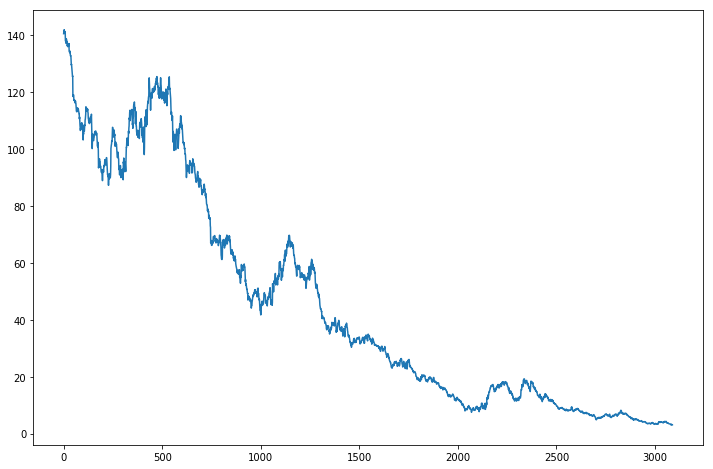

In [21]:
data = data.loc[:, 'Adj Close'].tolist()
plt.figure(figsize=(12, 8))
plt.plot(data)
plt.show()

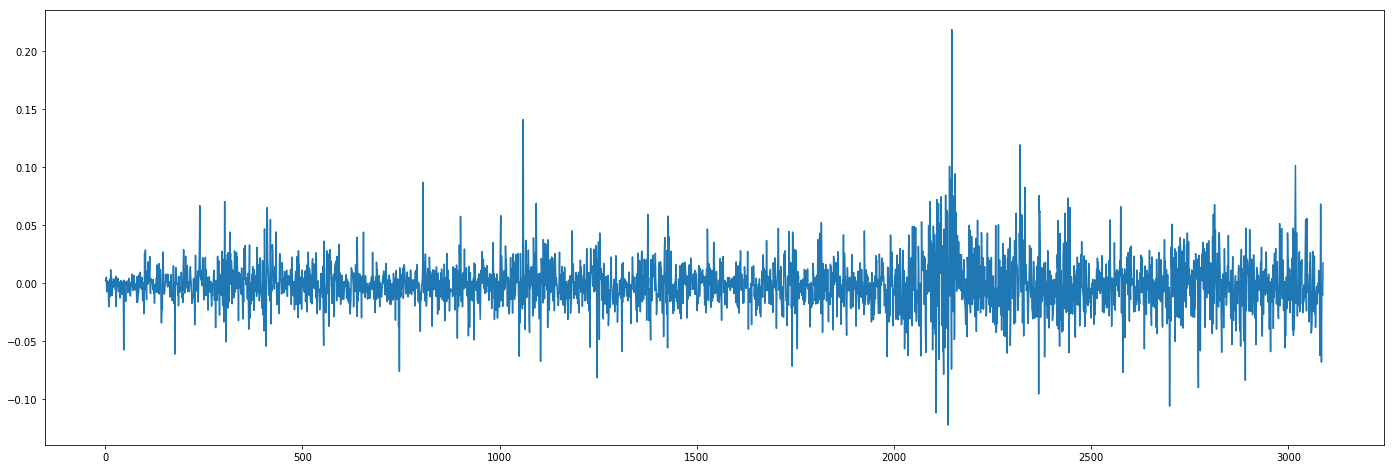

In [24]:
plt.figure(figsize=(24, 8))
plt.plot(data_changed)
plt.show()

In [25]:
WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

In [26]:
# Create time window
X, Y = [], []
for i in range(0, len(data), STEP):
    try:
        x_i = data[i:i + WINDOW]
        y_i = data[i + WINDOW + FORECAST]

#         last_close = x_i[WINDOW - 1]
#         next_close = y_i

#         if last_close < next_close:
#             y_i = [1, 0]
#         else:
#             y_i = [0, 1]
    except Exception as e:
        print(e)
        break
        
    X.append(x_i)
    Y.append(y_i)

list index out of range


In [27]:
print(len(X))
print(len(X))

3054
3054


In [28]:
import numpy as np
#X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [29]:
print(X.shape)
print(Y.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3054, 30)
(3054,)
(2443, 30)
(2443,)
(611, 30)
(611,)


In [30]:
model = Sequential()
model.add(Dense(64, input_dim=30, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('linear'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint('output/test_regr.hdf5', verbose=1, save_best_only=True)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [31]:
H = model.fit(X_train, Y_train, epochs=150, batch_size=128, verbose=1,
    validation_data=(X_test, Y_test), callbacks=[reduce_lr, checkpointer], shuffle=True)

Train on 2443 samples, validate on 611 samples
Epoch 1/150
2443/2443 [==============================] - 1s 241us/step - loss: 145255.0652 - acc: 0.0000e+00 - val_loss: 845.6526 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 845.65263, saving model to output/test_regr.hdf5
Epoch 2/150
2443/2443 [==============================] - 0s 72us/step - loss: 46498.4866 - acc: 0.0000e+00 - val_loss: 272.7046 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 845.65263 to 272.70461, saving model to output/test_regr.hdf5
Epoch 3/150
2443/2443 [==============================] - 0s 75us/step - loss: 14380.3059 - acc: 0.0000e+00 - val_loss: 124.3785 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 272.70461 to 124.37854, saving model to output/test_regr.hdf5
Epoch 4/150
2443/2443 [==============================] - 0s 74us/step - loss: 6514.1886 - acc: 0.0000e+00 - val_loss: 85.0491 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 124.37854 to 85.04911, sa

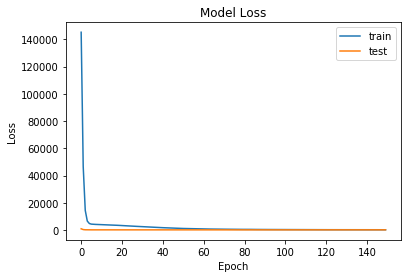

In [32]:
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['train', 'test'], loc='best')
plt.show()

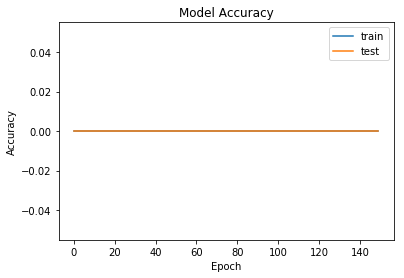

In [33]:
plt.figure()
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train', 'test'], loc='best')
plt.show()

[[1.]]


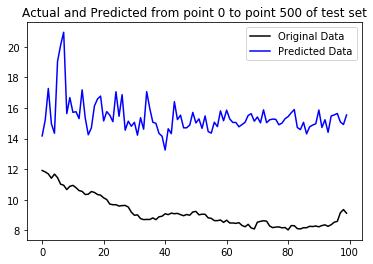

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(np.array(X_test))
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print(C/C.astype(np.float).sum(axis=1))

FROM = 0
TO = FROM + 500

original = Y_test[0:100]
predicted = pred[0:100]

plt.plot(original, color='black', label='Original Data')
plt.plot(predicted, color='blue', label='Predicted Data')
plt.legend(loc = 'best')
plt.title("Actual and Predicted from point {} to point {} of test set".format(FROM, TO))
plt.show()